# Multioutput Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib as pl
import os

import gumbi as gmb

Use gumbi's plotting defaults for stylistic consistency, good dataviz practice, and aesthetics. Use `gmb.style.default` if you don't have the Futura font installed.

In [2]:
plt.style.use(gmb.style.futura)

## Setup


Load in wide-form data and store as a DataSet. We must specify which columns are considered "outputs",
and additionally we may indicate which input and output variables should be treated as log-normal or logit-normal.

In [3]:
df = pd.read_pickle(gmb.data.example_dataset)
df = df[(df.Name == 'binary-pollen') & (df.Color == 'cyan') & (df.Metric == 'mean')]
outputs=['a', 'b', 'c', 'd', 'e', 'f']
log_vars=['Y', 'b', 'c', 'd', 'f']
logit_vars=['X', 'e']
ds = gmb.DataSet(df, outputs=outputs, log_vars=log_vars,logit_vars=logit_vars)
ds

DataSet:
	wide: [14 rows x 18 columns]
	tidy: [84 rows x 14 columns]
	outputs: ['a', 'b', 'c', 'd', 'e', 'f']
	inputs: ['Code', 'Position', 'Color', 'Z', 'lg10_Z', 'Name', 'Left', 'Right', 'Pair', 'Y', 'X', 'Metric']

## Train Model 


Train a multioutput GP on five amplification parameters, using an RBF + linear kernel on `lg10_Z` to
capture continuous variation along with a coregionalization kernel to allow for correlated but distinct behavior in
both the mean and noise across the parameters.

In [4]:
fit_params = ['a', 'b', 'c', 'd', 'e']
gp = gmb.GP(ds, outputs=fit_params)
n_p = len(fit_params)
gp.fit(continuous_dims='lg10_Z', linear_dims='lg10_Z');

## Marginal Parameter Predictions

Predict each parameter individually, allowing us to ensure the marginal uncertainty is calibrated correctly.

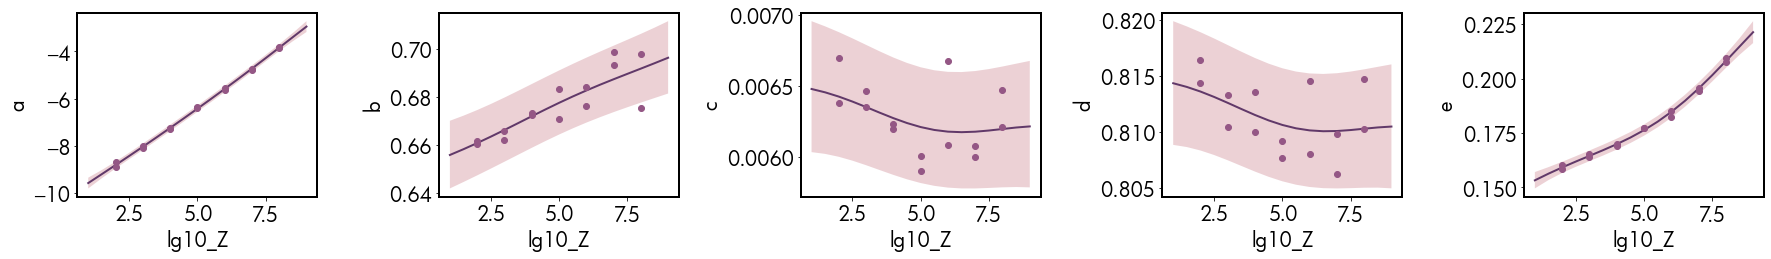

In [5]:
limits = gp.parray(lg10_Z=[1, 9])
x_pa = gp.prepare_grid(limits=limits, resolution=17)

axs = plt.subplots(1, n_p, figsize=(n_p * 5, 4))[1]

for ax, param in zip(np.atleast_1d(axs), fit_params):
    gp.predict_grid(output=param)

    y_upa = gp.predictions

    gmb.ParrayPlotter(x_pa, y_upa).plot(ax=ax)

    param_data = ds.tidy[(ds.tidy.Metric == 'mean') & (ds.tidy.Variable == param)]
    x = gp.parray(lg10_Z=param_data['lg10_Z'])
    y = param_data['Value']
    ax.plot(x, y, 'o', color=sns.cubehelix_palette()[-3])

plt.tight_layout()

## Correlated Parameter Predictions

Make joint predictions for all parameters, returning an MVUncertainParameterArray.

In [6]:
gp.prepare_grid(limits=gp.parray(lg10_Z=[1, 9]), resolution=5)
gp.predict_grid();

x_pa = gp.predictions_X
mvup = gp.predictions
mvup

('a', 'b', 'c', 'd', 'e')['μ', 'σ2']: [((-9.57788216, 0.65591025, 0.00647869, 0.81435251, 0.15328028), (0.01351727, 0.00011995, 0.00132116, 1.20592308e-05, 2.18737249e-04))
 ((-8.04047438, 0.66631188, 0.00635118, 0.8125933 , 0.16450185), (0.00474764, 0.00010449, 0.00116088, 1.05028843e-05, 8.23724475e-05))
 ((-6.42882047, 0.6775978 , 0.00621008, 0.81061539, 0.17630182), (0.00466895, 0.00010077, 0.00112398, 1.01568761e-05, 8.11646988e-05))
 ((-4.73002251, 0.6874157 , 0.00617728, 0.81007088, 0.19538906), (0.00474881, 0.00010521, 0.00116827, 1.05701722e-05, 8.23948966e-05))
 ((-2.94882945, 0.69637575, 0.00621459, 0.8104704 , 0.22129087), (0.01366521, 0.00012173, 0.0013391 , 1.22271471e-05, 2.21147610e-04))]

Sample from the joint distribution at each concentration to inspect the correlations between parameters across concentrations.

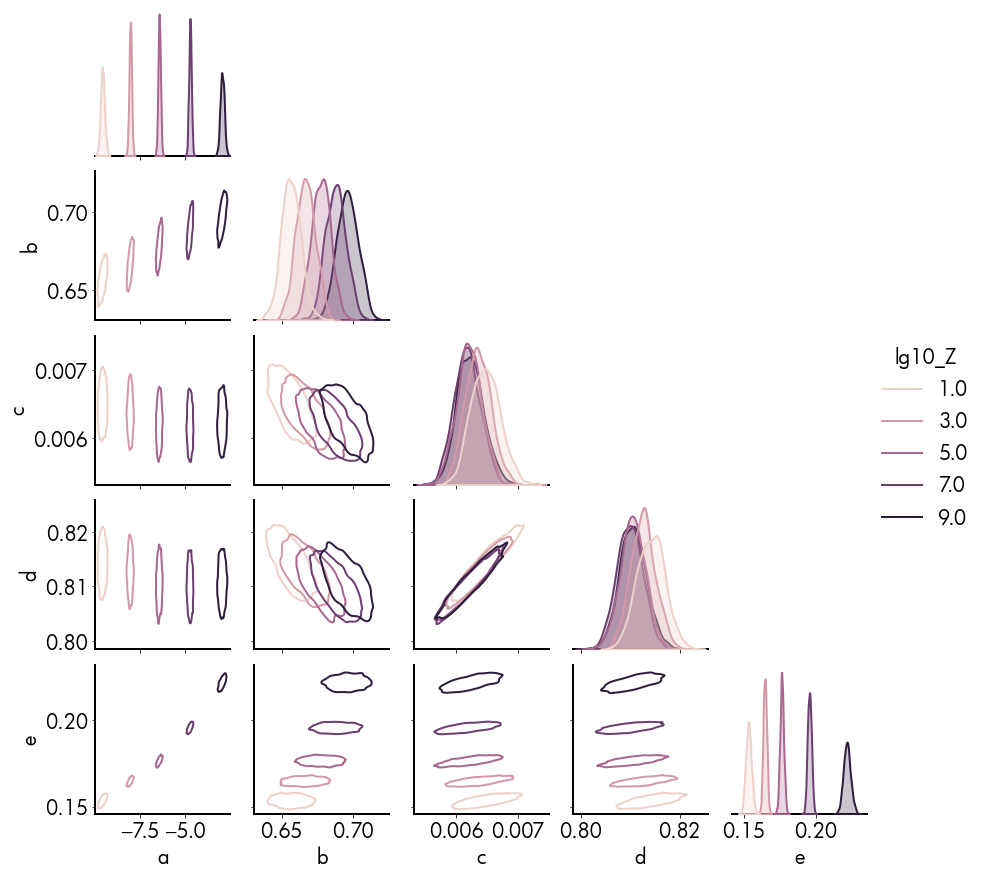

In [7]:
samples_df = pd.concat(
    [pd.DataFrame(point.dist.rvs(1000, random_state=i).as_dict()).assign(lg10_Z=copies.values()) for i, (point, copies) in enumerate(zip(mvup, x_pa))],
    ignore_index=True)

sns.pairplot(samples_df, hue='lg10_Z', kind='kde', corner=True, plot_kws={'levels': 1});